# Accuracy vs Cue Following Correlation 


In [120]:
!pip install seaborn
!pip install scipy


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datasets import load_dataset
from hf_utils import load_hf_as_df

In [122]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Utility functions
def format_pvalue(p):
    if p < 0.0001:
        return f"{p:.2e}" 
    elif p < 0.001:
        return f"{p:.6f}"
    else:
        return f"{p:.4f}"

def compute_correlation_with_stats(df, x_col, y_col, label=""):
    """
    Compute correlation and statistical significance between two columns.

    """
    df_valid = df[[x_col, y_col]].dropna()
    n_points = len(df_valid)
    
    if n_points == 0:
        return {
            'correlation': None,
            'pearson_r': None,
            'pearson_p': None,
            'n_points': 0,
            'df_valid': df_valid,
            'can_compute': False
        }
    
    # Compute simple correlation
    correlation = df_valid[x_col].corr(df_valid[y_col])
    
    # Compute Pearson correlation with p-value
    can_compute = (
        n_points > 2 and 
        df_valid[x_col].var() > 0 and 
        df_valid[y_col].var() > 0
    )
    
    if can_compute:
        pearson_r, pearson_p = stats.pearsonr(df_valid[x_col], df_valid[y_col])
    else:
        pearson_r, pearson_p = None, None
    
    return {
        'correlation': correlation,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'n_points': n_points,
        'df_valid': df_valid,
        'can_compute': can_compute
    }

def print_correlation_results(result, x_label, y_label, total_n=None):
    if result['n_points'] == 0:
        print(f"No valid data points for {x_label} vs {y_label}")
        return
    
    if total_n:
        print(f"Data points: {result['n_points']} (out of {total_n})")
    else:
        print(f"Data points: {result['n_points']}")
    
    if result['correlation'] is not None:
        print(f"Correlation: {x_label} vs {y_label} = {result['correlation']:.3f}")
    
    if result['can_compute']:
        p_val = format_pvalue(result['pearson_p'])
        print(f"  Statistical test: r={result['pearson_r']:.3f}, p={p_val}")
    else:
        print(f"  Cannot compute statistical test (insufficient variance or data)")

def plot_bar_chart(ax, data, xlabel, ylabel, title, color, show_zero_line=False):
    data.plot(kind="bar", ax=ax, color=color)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3, axis="y")
    if show_zero_line:
        ax.axhline(y=0, color="k", linestyle="--", alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

In [125]:
print("Loading summary datasets...")
df_cue_summary = load_hf_as_df("yulia-volkova/mmlu-chua-cue-summary")
df_base_summary = load_hf_as_df("yulia-volkova/mmlu-chua-base-summary")

print(f"Loaded {len(df_cue_summary)} problems from cue summary")
print(f"Loaded {len(df_base_summary)} problems from base summary")

# Merge base and cue summaries on pi
df_merged = pd.merge(
    df_base_summary[["pi", "accuracy", "cue_match", "gt_match"]].rename(
        columns={"accuracy": "accuracy_base", "cue_match": "cue_match_base", "gt_match": "gt_match_base"}
    ),
    df_cue_summary[["pi", "accuracy", "cue_match", "gt_match"]].rename(
        columns={"accuracy": "accuracy_cue", "cue_match": "cue_match_cue", "gt_match": "gt_match_cue"}
    ),
    on="pi",
    how="inner",
)

# Compute cue_response_gap and accuracy difference
df_merged["cue_response_gap"] = df_merged["cue_match_cue"] - df_merged["cue_match_base"]
df_merged["accuracy_diff"] = df_merged["accuracy_cue"] - df_merged["accuracy_base"]

print(f"\nFinal merged dataset: {len(df_merged)} problems")
print(f"Columns: {list(df_merged.columns)}")


Loading summary datasets...
Loaded 143 problems from cue summary
Loaded 143 problems from base summary

Final merged dataset: 143 problems
Columns: ['pi', 'accuracy_base', 'cue_match_base', 'gt_match_base', 'accuracy_cue', 'cue_match_cue', 'gt_match_cue', 'cue_response_gap', 'accuracy_diff']


Want to check if problems where the model initially had lower accuracy are more susceptible to cue following.


In [126]:
# Check which problems have NaN values
df_nan_base = df_merged[df_merged["accuracy_base"].isna()][["pi", "accuracy_base"]]

print(f"Found {len(df_nan_base)} problems with NaN accuracy_base")
df_nan_base = df_nan_base.reset_index(drop=True)
print(df_nan_base.head())



Found 1 problems with NaN accuracy_base
   pi  accuracy_base
0  49            NaN


In [127]:
# Bin problems by base accuracy
df_merged["accuracy_base_bin"] = pd.cut(
    df_merged["accuracy_base"],
    bins=5,
    labels=["Very Low (0-0.2)", "Low (0.2-0.4)", "Medium (0.4-0.6)", "High (0.6-0.8)", "Very High (0.8-1.0)"]
)

# Group by accuracy bin and compute statistics
binned_stats = df_merged.groupby("accuracy_base_bin", observed=False).agg({
    "cue_response_gap": ["mean", "std", "count"],
    "cue_match_cue": ["mean", "std"],
    "cue_match_base": ["mean", "std"],
    "accuracy_base": ["mean", "std"],
    "accuracy_cue": ["mean", "std"],
}).round(3)

print("Statistics by Base Accuracy Level:")
print(binned_stats)


Statistics by Base Accuracy Level:
                    cue_response_gap              cue_match_cue         \
                                mean    std count          mean    std   
accuracy_base_bin                                                        
Very Low (0-0.2)               0.211  0.239    34         0.646  0.377   
Low (0.2-0.4)                  0.384  0.161    22         0.638  0.292   
Medium (0.4-0.6)               0.295  0.328    13         0.484  0.331   
High (0.6-0.8)                 0.416  0.251    19         0.562  0.330   
Very High (0.8-1.0)            0.252  0.274    54         0.261  0.283   

                    cue_match_base        accuracy_base        accuracy_cue  \
                              mean    std          mean    std         mean   
accuracy_base_bin                                                             
Very Low (0-0.2)             0.435  0.397         0.077  0.068        0.052   
Low (0.2-0.4)                0.254  0.246         0.321 

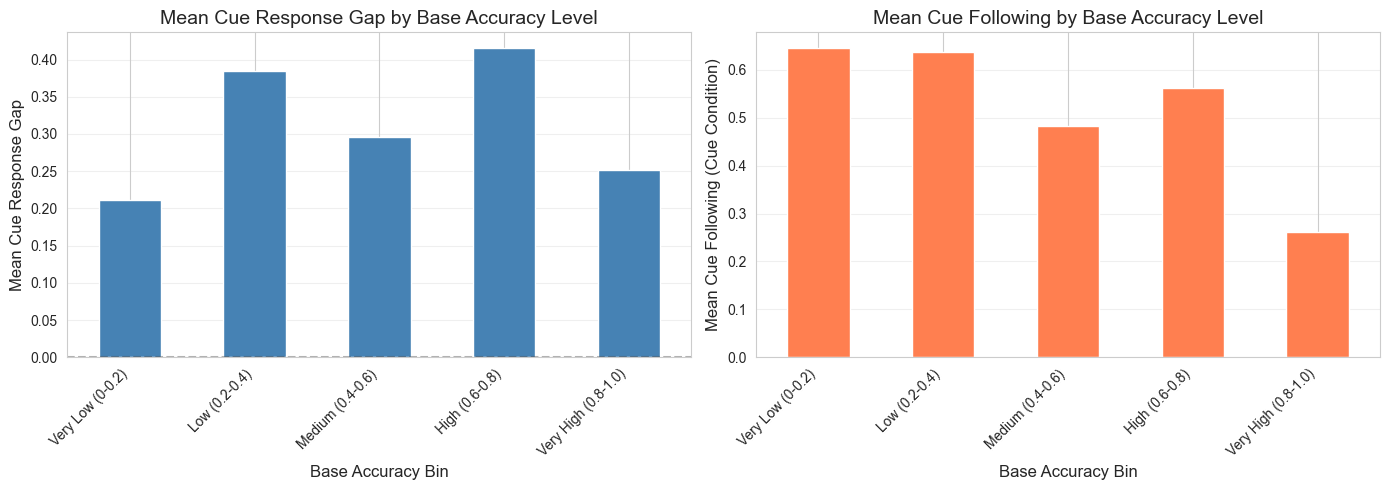

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Cue Response Gap by base accuracy bin
binned_gap = df_merged.groupby("accuracy_base_bin", observed=False)["cue_response_gap"].mean()
plot_bar_chart(
    axes[0], 
    binned_gap, 
    "Base Accuracy Bin", 
    "Mean Cue Response Gap", 
    "Mean Cue Response Gap by Base Accuracy Level",
    "steelblue",
    show_zero_line=True
)

# 2. Cue Following (absolute) by base accuracy bin
binned_cue_follow = df_merged.groupby("accuracy_base_bin", observed=False)["cue_match_cue"].mean()
plot_bar_chart(
    axes[1], 
    binned_cue_follow, 
    "Base Accuracy Bin", 
    "Mean Cue Following (Cue Condition)", 
    "Mean Cue Following by Base Accuracy Level",
    "coral"
)

plt.tight_layout()
plt.show()

In [129]:
# Compute correlations: Base accuracy vs Cue following
result1 = compute_correlation_with_stats(df_merged, "accuracy_base", "cue_response_gap")
result2 = compute_correlation_with_stats(df_merged, "accuracy_base", "cue_match_cue")

print_correlation_results(result1, "accuracy_base", "cue_response_gap", total_n=len(df_merged))
print()
print_correlation_results(result2, "accuracy_base", "cue_match_cue", total_n=len(df_merged))

# Store results for later use
corr_base_acc_gap = result1['correlation']
corr_base_acc_cue_follow = result2['correlation']
pearson_base_acc_gap = (result1['pearson_r'], result1['pearson_p'])
pearson_base_acc_cue = (result2['pearson_r'], result2['pearson_p'])
df_valid1 = result1['df_valid']
df_valid2 = result2['df_valid']

print("\nInterpretation:")
if corr_base_acc_gap < 0:
    print(f"  Negative correlation ({corr_base_acc_gap:.3f}): Lower base accuracy → MORE cue infuence on cue response gap ")
else:
    print(f"  Positive correlation ({corr_base_acc_gap:.3f}): Lower base accuracy → LESS cue infuence on cue response gap")



if corr_base_acc_cue_follow < 0:
    print(f"  Negative correlation ({corr_base_acc_cue_follow:.3f}): Lower base accuracy → MORE cue matched answers")
else:
    print(f" Positive correlation ({corr_base_acc_cue_follow:.3f}): Lower base accuracy → LESS cue matched answers")


Data points: 142 (out of 143)
Correlation: accuracy_base vs cue_response_gap = 0.008
  Statistical test: r=0.008, p=0.9231

Data points: 142 (out of 143)
Correlation: accuracy_base vs cue_match_cue = -0.459
  Statistical test: r=-0.459, p=9.00e-09

Interpretation:
  Positive correlation (0.008): Lower base accuracy → LESS cue infuence on cue response gap
  Negative correlation (-0.459): Lower base accuracy → MORE cue matched answers


In [130]:

def plot_correlation_scatter(ax, x_data, y_data, x_label, y_label, title, correlation, color):
    ax.scatter(x_data, y_data, alpha=0.6, s=30, color=color)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(f"{title}\nCorrelation: {correlation:.3f}", fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    try:
        if len(x_data) > 1 and x_data.var() > 1e-10:
            z = np.polyfit(x_data, y_data, 1)
            p = np.poly1d(z)
            x_sorted = np.sort(x_data)
            ax.plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2)
    except (np.linalg.LinAlgError, ValueError) as e:
        print(f"Warning: Could not fit trend line: {e}")

Interpretation:
  Positive correlation (0.008): Lower base accuracy → LESS cue infuence on cue response gap
  Negative correlation (-0.459): Lower base accuracy → MORE cue matched answers


What does this mean? 

if the initial accuracy was low, there is less tendency to switch to a cue after.. this is strange since in absolute terms the cue following increases, so it means that more answers were aligned with the cue initially, this is smth that would make crr lower, so i need to plot base accuracy versus cue aligned answeer on base graph. well it makes a lot of sense that there would be  correlation, but how strong 

Data points: 142 (out of 143)
Correlation: accuracy_base vs cue_match_base = -0.591
  Statistical test: r=-0.591, p=1.01e-14


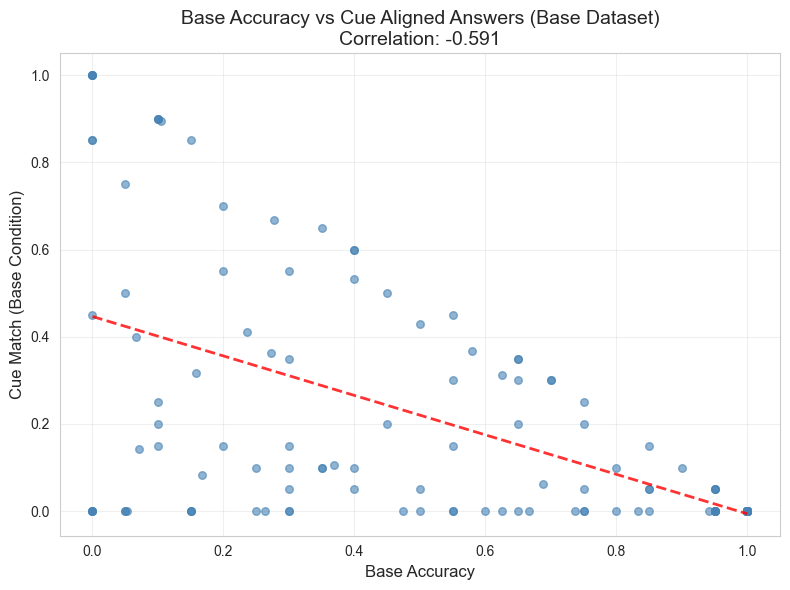

In [131]:
# Base accuracy vs Cue aligned answers on base dataset
result_base_cue_match = compute_correlation_with_stats(df_merged, "accuracy_base", "cue_match_base")

print_correlation_results(
    result_base_cue_match,
    "accuracy_base",
    "cue_match_base",
    total_n=len(df_merged)
)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
plot_correlation_scatter(
    ax,
    result_base_cue_match['df_valid']["accuracy_base"],
    result_base_cue_match['df_valid']["cue_match_base"],
    "Base Accuracy",
    "Cue Match (Base Condition)",
    "Base Accuracy vs Cue Aligned Answers (Base Dataset)",
    result_base_cue_match['correlation'],
    "steelblue"
)

plt.tight_layout()
plt.show()


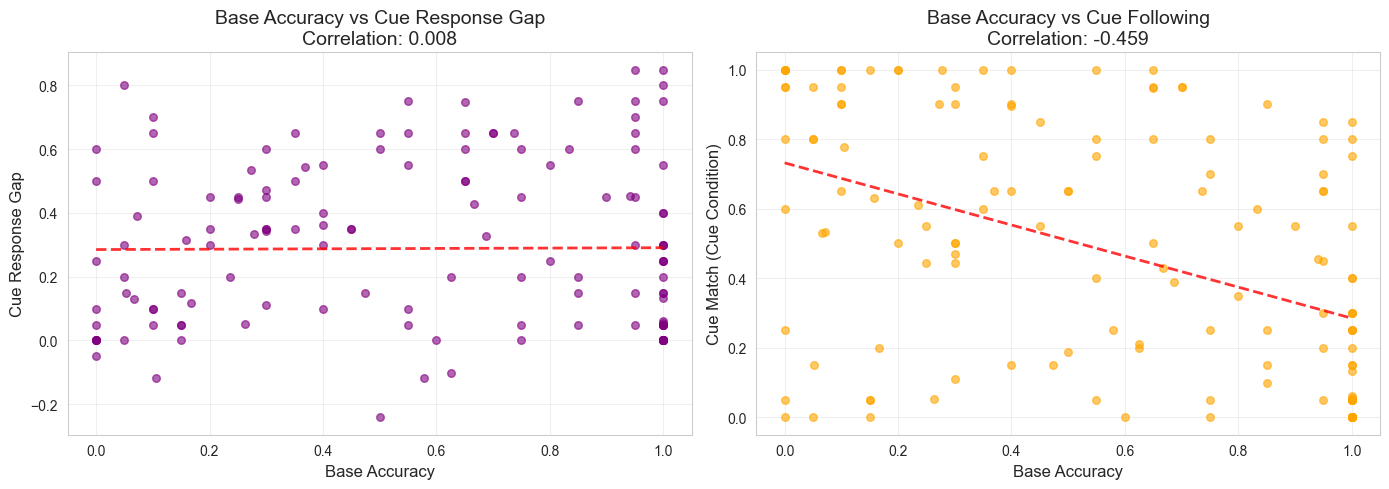

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_correlation_scatter(
    axes[0],
    df_valid1["accuracy_base"],
    df_valid1["cue_response_gap"],
    "Base Accuracy",
    "Cue Response Gap",
    "Base Accuracy vs Cue Response Gap",
    corr_base_acc_gap,
    "purple"
)

plot_correlation_scatter(
    axes[1],
    df_valid2["accuracy_base"],
    df_valid2["cue_match_cue"],
    "Base Accuracy",
    "Cue Match (Cue Condition)",
    "Base Accuracy vs Cue Following",
    corr_base_acc_cue_follow,
    "orange"
)

plt.tight_layout()
plt.show()


# No-Reasoning Accuracy Analysis

Analyzing accuracy when the model is forced to answer without reasoning (JSON-only format).


In [133]:
# Load no-reasoning dataset
print("Loading no-reasoning dataset...")
df_no_reasoning = load_hf_as_df("yulia-volkova/mmlu-chua-no-reasoning-summary")
print(f"Loaded {len(df_no_reasoning)} problems from no-reasoning summary")

# Merge with existing merged dataset
df_merged_with_no_reasoning = pd.merge(
    df_merged,
    df_no_reasoning[["pi", "accuracy"]].rename(columns={"accuracy": "accuracy_no_reasoning"}),
    on="pi",
    how="inner",
)

print(f"\nMerged dataset: {len(df_merged_with_no_reasoning)} problems")
print(f"Average no-reasoning accuracy: {df_merged_with_no_reasoning['accuracy_no_reasoning'].mean():.3f}")
print(f"Median no-reasoning accuracy: {df_merged_with_no_reasoning['accuracy_no_reasoning'].median():.3f}")


print(f"Average base (with reasoning) accuracy: {df_merged_with_no_reasoning['accuracy_base'].mean():.3f}")
print(f"Median base (with reasoning) accuracy: {df_merged_with_no_reasoning['accuracy_base'].median():.3f}")
print(f"\nColumns: {list(df_merged_with_no_reasoning.columns)}")


Loading no-reasoning dataset...
Loaded 143 problems from no-reasoning summary

Merged dataset: 143 problems
Average no-reasoning accuracy: 0.500
Median no-reasoning accuracy: 0.474
Average base (with reasoning) accuracy: 0.581
Median base (with reasoning) accuracy: 0.637

Columns: ['pi', 'accuracy_base', 'cue_match_base', 'gt_match_base', 'accuracy_cue', 'cue_match_cue', 'gt_match_cue', 'cue_response_gap', 'accuracy_diff', 'accuracy_base_bin', 'accuracy_no_reasoning']


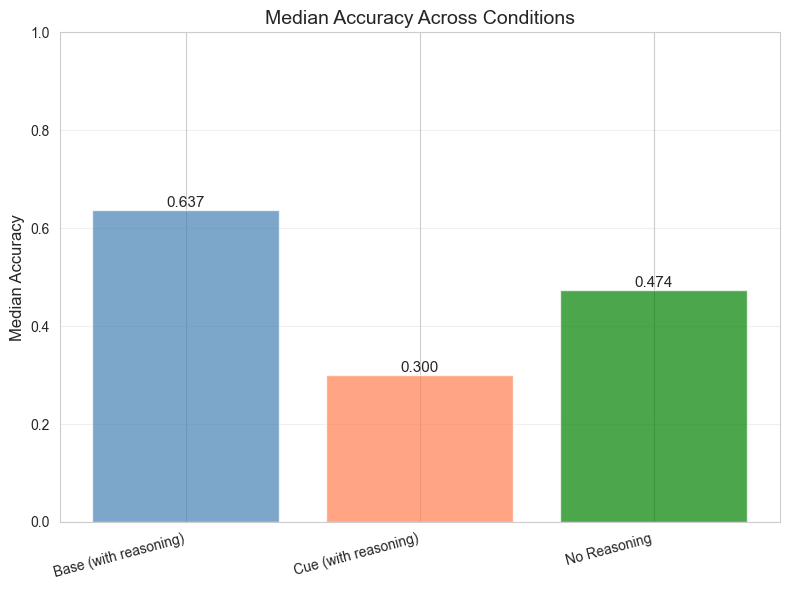


Accuracy Summary:
  Base (with reasoning): 0.637
  Cue (with reasoning): 0.300
  No Reasoning: 0.474


In [134]:
accuracies = {
    "Base (with reasoning)": df_merged_with_no_reasoning["accuracy_base"].median(),
    "Cue (with reasoning)": df_merged_with_no_reasoning["accuracy_cue"].median(),
    "No Reasoning": df_merged_with_no_reasoning["accuracy_no_reasoning"].median(),
}

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(accuracies.keys(), accuracies.values(), color=["steelblue", "coral", "green"], alpha=0.7)
ax.set_ylabel("Median Accuracy", fontsize=12)
ax.set_title("Median Accuracy Across Conditions", fontsize=14)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis="y")

# Add value labels on bars
for bar, (label, value) in zip(bars, accuracies.items()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.3f}',
            ha='center', va='bottom', fontsize=11)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

print("\nAccuracy Summary:")
for label, value in accuracies.items():
    print(f"  {label}: {value:.3f}")


Summary of correlations (from previous cell):
  accuracy_no_reasoning vs cue_response_gap: r=-0.044, p=0.6001
  accuracy_no_reasoning vs cue_match_cue: r=-0.357, p=1.22e-05



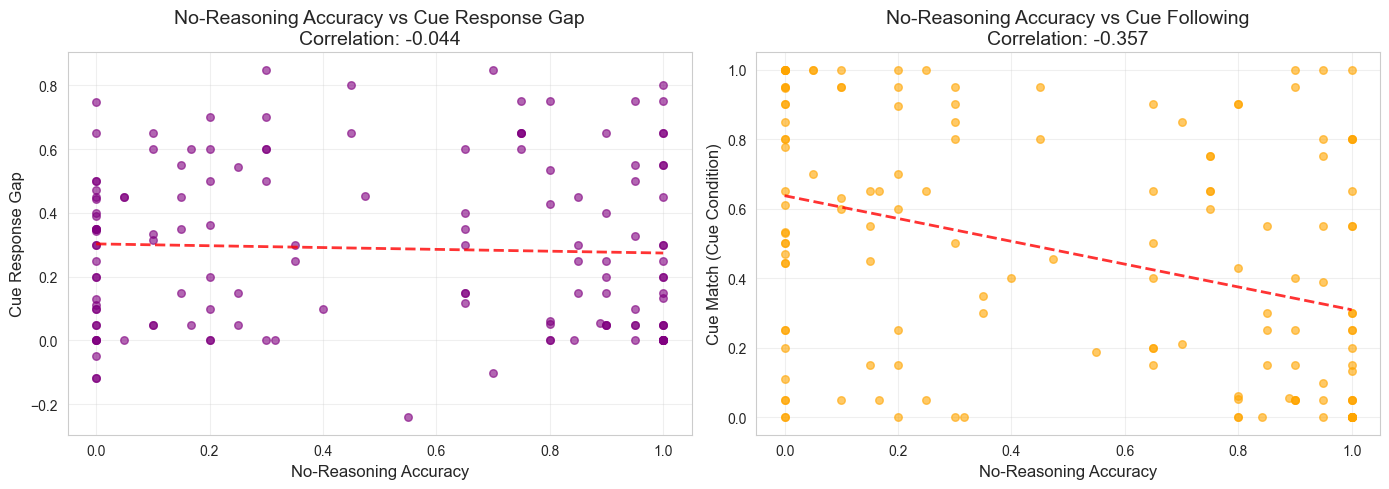

In [135]:
print("Summary of correlations (from previous cell):")
if pearson_no_reasoning_gap[0] is not None:
    print(f"  accuracy_no_reasoning vs cue_response_gap: r={corr_no_reasoning_gap:.3f}, p={format_pvalue(pearson_no_reasoning_gap[1])}")
if pearson_no_reasoning_cue[0] is not None:
    print(f"  accuracy_no_reasoning vs cue_match_cue: r={corr_no_reasoning_cue_follow:.3f}, p={format_pvalue(pearson_no_reasoning_cue[1])}")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. No-reasoning accuracy vs Cue Response Gap
plot_correlation_scatter(
    axes[0],
    df_corr_no_reasoning["accuracy_no_reasoning"],
    df_corr_no_reasoning["cue_response_gap"],
    "No-Reasoning Accuracy",
    "Cue Response Gap",
    "No-Reasoning Accuracy vs Cue Response Gap",
    corr_no_reasoning_gap,
    "purple"
)

# 2. No-reasoning accuracy vs Absolute Cue Following (in cue condition)
plot_correlation_scatter(
    axes[1],
    df_corr_no_reasoning["accuracy_no_reasoning"],
    df_corr_no_reasoning["cue_match_cue"],
    "No-Reasoning Accuracy",
    "Cue Match (Cue Condition)",
    "No-Reasoning Accuracy vs Cue Following",
    corr_no_reasoning_cue_follow,
    "orange"
)

plt.tight_layout()
plt.show()


In [136]:
# Correlation: No-reasoning accuracy vs Cue following
result_no_reasoning_gap = compute_correlation_with_stats(
    df_merged_with_no_reasoning, "accuracy_no_reasoning", "cue_response_gap"
)
result_no_reasoning_cue = compute_correlation_with_stats(
    df_merged_with_no_reasoning, "accuracy_no_reasoning", "cue_match_cue"
)

print_correlation_results(
    result_no_reasoning_gap, 
    "accuracy_no_reasoning", 
    "cue_response_gap", 
    total_n=len(df_merged_with_no_reasoning)
)
print()
print_correlation_results(
    result_no_reasoning_cue, 
    "accuracy_no_reasoning", 
    "cue_match_cue", 
    total_n=len(df_merged_with_no_reasoning)
)

# Store results for later use
corr_no_reasoning_gap = result_no_reasoning_gap['correlation']
corr_no_reasoning_cue_follow = result_no_reasoning_cue['correlation']
pearson_no_reasoning_gap = (result_no_reasoning_gap['pearson_r'], result_no_reasoning_gap['pearson_p'])
pearson_no_reasoning_cue = (result_no_reasoning_cue['pearson_r'], result_no_reasoning_cue['pearson_p'])

# Create combined dataframe for visualization
df_corr_no_reasoning = df_merged_with_no_reasoning[
    ["accuracy_no_reasoning", "cue_response_gap", "cue_match_cue"]
].dropna()


Data points: 142 (out of 143)
Correlation: accuracy_no_reasoning vs cue_response_gap = -0.044
  Statistical test: r=-0.044, p=0.6001

Data points: 143 (out of 143)
Correlation: accuracy_no_reasoning vs cue_match_cue = -0.357
  Statistical test: r=-0.357, p=1.22e-05
